<a href="https://colab.research.google.com/github/markwreinke/OrganStopClassifier/blob/main/AudioClassificationMedium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tutorial taken from https://medium.com/@hasithsura/audio-classification-d37a82d6715 

Be sure to look at the github, as the article doesn't have the whole code: https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb


In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [2]:
# Mounting google drive into colab, and ensuring we are in the data folder
from google.colab import drive
drive.mount("/content/drive")

dir = "/content/drive/My Drive/ESC-50-master"
print(os.getcwd())

if(os.getcwd() != dir):
  os.chdir(dir)

print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/ESC-50-master


In [3]:
# Here we are reading a comma separated values (CSV) file using pandas into the 
# variable df. df is type a 2D data structure with labeled axes, 
# as a DataFrame or TextParser
df = pd.read_csv('meta/esc50.csv')

In [4]:
# Return the first n rows of the DataFrame. n defaults to 5 with no args
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
# The data was sorted into 5 "Cross-validation" folds, in which here, the first
# four are used as training data, and the fifth is a validation set
# Here's the paper: http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [6]:
# Load a filewith librosa, and display its sampling rate and length
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [8]:
# Here we are going to convert a Spectrogram into an image
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

  # This spectrogram is normalized using z score normalization and 
  # scaled using min-max scaling so its values lie between 0 and 255

In [9]:
# This function give a mel spectrogram of the given file
#  sr=None -> Librosa should use the native sampling rate of 44.1KHz to load the audio data instead of the default of 22.05KHz
#  Next the first 5 seconds of given audio is extracted
#  2048 samples are chosen for each window (about 46ms)
#  A hop_length of 512 samples is chose, meaning the window is moved by skipping 512 samples to get the next time frame
#  The number of mel filters is 128, makes the height of the spectrogram image 128
#  fmin and fmax are the lowest and highest frequencies
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav, sr = librosa.load(file_path, sr=sr)
  if wav.shape[0]<5*sr:
     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]

  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

  #Librosa squares the magnitude of the spectrogram when constructing Mel Spectrogram, so we use power_to_db to convert power magnitude to decipels. top_db is used to threshold the output.
  spec_db=librosa.power_to_db(spec, top_db=top_db)
  return spec_db

In [10]:
# This is us loading data into pytorch by building dataloaders to
# preprocess and load data.

class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i = {}
    self.i2c = {}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category] = i
      self.i2c[i] = category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base, row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])

  def __len__(self):
     return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

train_data = ESC50Data('audio', train, 'filename', 'category')
valid_data = ESC50Data('audio', valid, 'filename', 'category')
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 16, shuffle = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [11]:
# Build a model using a pre-trained model, resnet34
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device = torch.device('cpu')

resnet_model = resnet34(pretrained = True)
resnet_model.fc = nn.Linear(512, 50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size = (7,7), stride=(2,2), padding = (3, 3), bias = False)
resnet_model = resnet_model.to(device)

# The first conv1 layer of resnet34 accepts 3 channels so it is changed to accept 1 channel.
# The final fc layer generates output for 1000 categoris so it is changed to 50 categories




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [13]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  return optimizer

In [14]:
# Train the model
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr = learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

def train(model, loss_fn, train_loser, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr = None):
  for epoch in tqdm(range(1,epochs+1)):
     model.train()
     batch_losses=[]
     if change_lr:
       optimizer = change_lr(optimizer, epoch)
     for i, data in enumerate(train_loader):
       x,y = data
       optimizer.zero_grad()
       x = x.to(device, dtype = torch.float32)
       y = y.to(device, dtype = torch.long)
       y_hat = model(x)
       loss = loss_fn(y_hat, y)
       loss.backward()
       batch_losses.append(loss.item())
       optimizer.step()
     train_losses.append(batch_losses)
     print(f'Epoch = {epoch} Train-Loss : {np.mean(train_losses[-1])}')
     model.eval()
     batch_losses=[]
     trace_y = []
     trace_yhat = []

     for i, data in enumerate(valid_loader):
       x,y = data
       x = x.to(device, dtype=torch.float32)
       y = y.to(device, dtype = torch.long)
       y_hat = model(x)
       loss = loss_fn(y_hat, y)
       trace_y.append(y.cpu().detach().numpy())
       trace_yhat.append(y_hat.cpu().detach().numpy())
       batch_losses.append(loss.item())

     valid_losses.append(batch_losses)
     trace_y = np.concatenate(trace_y)
     trace_yhat = np.concatenate(trace_yhat)
     accuracy = np.mean(trace_yhat.argmax(axis = 1) == trace_y)
     print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Epoch = 1 Train-Loss : 2.4670721137523652
Epoch - 1 Valid-Loss : 1.838047149181366 Valid-Accuracy : 0.5
Epoch = 2 Train-Loss : 1.17205652654171
Epoch - 2 Valid-Loss : 1.5032180213928223 Valid-Accuracy : 0.5675
Epoch = 3 Train-Loss : 0.7227743658423423
Epoch - 3 Valid-Loss : 1.366144278049469 Valid-Accuracy : 0.635
Epoch = 4 Train-Loss : 0.41935124464333057
Epoch - 4 Valid-Loss : 1.591874840259552 Valid-Accuracy : 0.5975
Epoch = 5 Train-Loss : 0.3184312891960144
Epoch - 5 Valid-Loss : 1.582233418226242 Valid-Accuracy : 0.595
Epoch = 6 Train-Loss : 0.2646806669980288
Epoch - 6 Valid-Loss : 1.2127186977863311 Valid-Accuracy : 0.6725
Epoch = 7 Train-Loss : 0.22681223645806312
Epoch - 7 Valid-Loss : 1.3835820364952087 Valid-Accuracy : 0.6725
Epoch = 8 Train-Loss : 0.1972420266829431
Epoch - 8 Valid-Loss : 1.3868506807088852 Valid-Accuracy : 0.6875
Epoch = 9 Train-Loss : 0.17719727667048574
Epoch - 9 Valid-Loss : 1.3409508490562438 Valid-Accuracy : 0.67
Changed learning rate to 2e-05
Epoch =

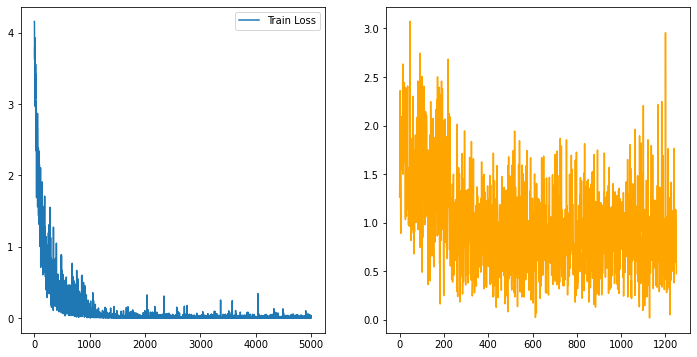

In [15]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')